In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

In [1]:
from zipfile import ZipFile
import io

def read_gdf_from_zip(zip_fp):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage)
    inside the ZipFile.
    """
    with ZipFile(zip_fp) as z:
        # Lists all files inside the ZipFile, here assumes that there is only a single file inside
        layer = z.namelist()[0]
        data = gpd.read_file(io.BytesIO(z.read(layer)))
    return data

In [ ]:
# Filepaths
stops = gpd.read_file('L3_data/pt_stops_helsinki.gpkg')
buildings = read_gdf_from_zip('L3_data/building_points_helsinki.zip')

In [2]:
stops.head()

,stop_name,stop_lat,stop_lon,stop_id,geometry
0,Ritarihuone,60.169460,24.956670,1010102,POINT (24.95667 60.16946)
1,Kirkkokatu,60.171270,24.956570,1010103,POINT (24.95657 60.17127)
2,Kirkkokatu,60.170293,24.956721,1010104,POINT (24.95672 60.17029)
3,Vironkatu,60.172580,24.956554,1010105,POINT (24.95655 60.17258)
4,Vironkatu,60.172990,24.956380,1010106,POINT (24.95638 60.17299)


In [4]:
buildings.head()

,name,geometry
0,None,POINT (24.85584 60.20727)
1,Uimastadion,POINT (24.93045 60.18882)
2,None,POINT (24.95113 60.16994)
3,Hartwall Arena,POINT (24.92918 60.20570)
4,Talli,POINT (24.92607 60.21346)


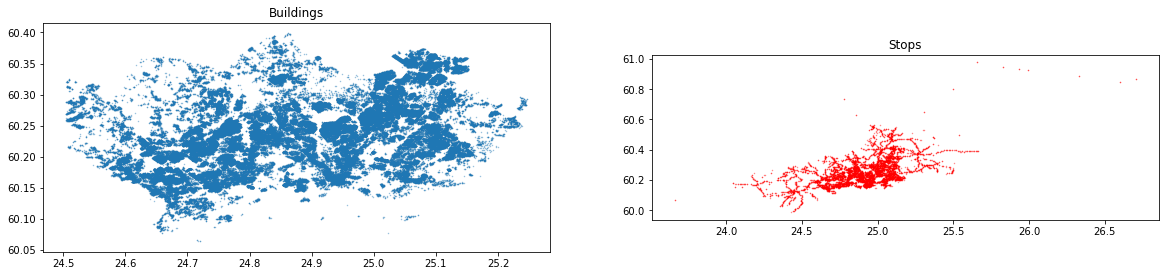

In [6]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot buildings
buildings.plot(ax=axes[0],markersize=0.2, alpha=0.5)
axes[0].set_title('Buildings')

# Plot stops
stops.plot(ax=axes[1], markersize=0.2, alpha=0.5, color='red')
axes[1].set_title('Stops');

In [7]:
from sklearn.neighbors import BallTree
import numpy as np

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

In [8]:
# Find closest public transport stop for each building and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(buildings, stops, return_dist=True)

# And the result looks like ..
closest_stops

,stop_name,stop_lat,stop_lon,stop_id,geometry,distance
0,Muusantori,60.207490,24.857450,1304138,POINT (24.85745 60.20749),180.521584
1,Eläintarha,60.192490,24.930840,1171120,POINT (24.93084 60.19249),372.665221
2,Senaatintori,60.169010,24.950460,1020450,POINT (24.95046 60.16901),119.425777
3,Veturitie,60.206610,24.929680,1174112,POINT (24.92968 60.20661),106.762619
4,Autokuljetuskeskus 1,60.218810,24.923110,1286161,POINT (24.92311 60.21881),631.794206
...,...,...,...,...,...,...
158726,Bredantie,60.212770,24.723210,3170222,POINT (24.72321 60.21277),200.454057
158727,Kasavuori,60.211112,24.699637,3170256,POINT (24.69964 60.21111),262.973726
158728,Kandidaatintie,60.218180,24.736987,3170245,POINT (24.73699 60.21818),175.043184
158729,Uimahalli,60.215660,24.712090,3170213,POINT (24.71209 60.21566),139.212653


In [9]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_stops = closest_stops.rename(columns={'geometry': 'closest_stop_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
buildings = buildings.join(closest_stops)

# Let's see what we have
buildings.head()

,name,geometry,stop_name,stop_lat,stop_lon,stop_id,closest_stop_geom,distance
0,None,POINT (24.85584 60.20727),Muusantori,60.20749,24.85745,1304138,POINT (24.85745 60.20749),180.521584
1,Uimastadion,POINT (24.93045 60.18882),Eläintarha,60.19249,24.93084,1171120,POINT (24.93084 60.19249),372.665221
2,None,POINT (24.95113 60.16994),Senaatintori,60.16901,24.95046,1020450,POINT (24.95046 60.16901),119.425777
3,Hartwall Arena,POINT (24.92918 60.20570),Veturitie,60.20661,24.92968,1174112,POINT (24.92968 60.20661),106.762619
4,Talli,POINT (24.92607 60.21346),Autokuljetuskeskus 1,60.21881,24.92311,1286161,POINT (24.92311 60.21881),631.794206


In [10]:
buildings['distance'].describe()


count    158731.000000
mean        299.288617
std         372.787458
min           1.358302
25%         133.853322
50%         218.742047
75%         341.648944
max        7153.941499
Name: distance, dtype: float64

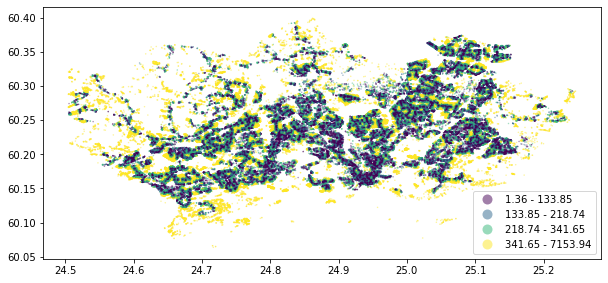

In [11]:
buildings.plot(column='distance', markersize=0.2, alpha=0.5, 
               figsize=(10,10), scheme='quantiles', k=4,
               legend=True)

In [12]:
from shapely.geometry import LineString

# Create a link (LineString) between building and stop points
buildings['link'] = buildings.apply(lambda row: LineString([row['geometry'], row['closest_stop_geom']]), axis=1)

# Set link as the active geometry
building_links = buildings.copy()
building_links = building_links.set_geometry('link')

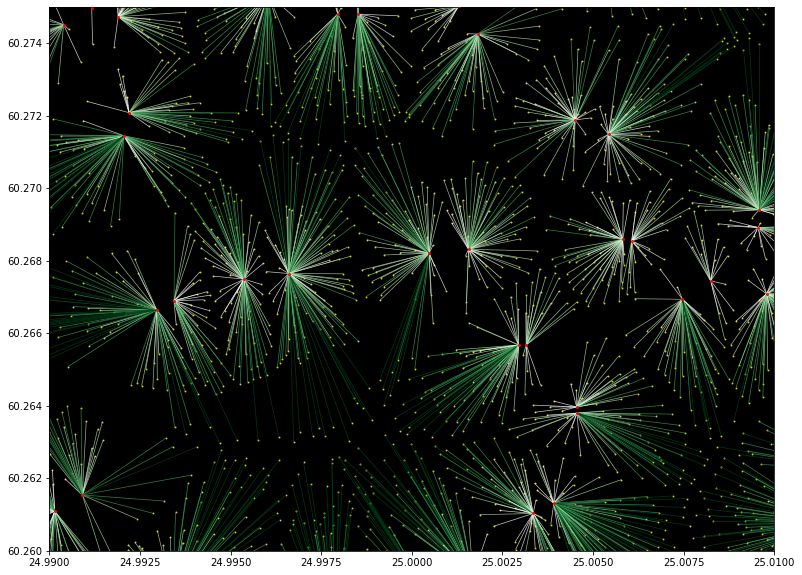

In [15]:
# Plot the connecting links between buildings and stops and color them based on distance
ax = building_links.plot(column='distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = buildings.plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
ax = stops.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Zoom closer
ax.set_xlim([24.99, 25.01])
ax.set_ylim([60.26, 60.275])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')